
## Time series clustering exercise
## Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. Download it programmatically and move it to PUIdata

Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
## You can use zipfile module in python to unzip the files

it should be installed in your system, but if it is not you can get the code with wget from here https://github.com/python/cpython/blob/2.7/Lib/zipfile.py remembering to use the raw link (or you can use the usual shell commands)



## Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))
## TASKS:

1. get and prep your data.
2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
in **a few** clusters (as discussed there is no real good, sound way to 
decide what a good number is here. try a few options, keeping in mind 
a few is more than a couple, but i recommand you stay within the 
single digit numbers)

3. plot the cluster centers (if you used K means those are the means of 
the clusters). you can plot for example the cluster centers overlayed on 
each time series (using the alpha channel to control the opacity in the 
plot may be helpful here).

4. Use another clustering algorithm (of your choice)

5. overlay your data on a NYC map: you can use shapefiles for the 
zip codes and different colors for different clusters

6. Compare the results of the 2 algorithms

7. attempt an interpretation. this is dangerous ground: clustering is 
an exploratory tool so you do not want to jump to conclusions because 
you see some clusters! but seeing structure in your data can inform 
your next moves as an investigator. 

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. Always when you apply a moachine learning model you should standardize the data or whiten it. These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening standardizes each feature" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

#### So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.

From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.


In [1]:
!wget https://github.com/fedhere/PUI2018_fb55/blob/master/HW12_fb55/zbp{00..14}totals.zip?raw=true

--2018-12-11 21:01:17--  https://github.com/fedhere/PUI2018_fb55/blob/master/HW12_fb55/zbp00totals.zip?raw=true
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp00totals.zip [following]
--2018-12-11 21:01:17--  https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp00totals.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW12_fb55/zbp00totals.zip [following]
--2018-12-11 21:01:17--  https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW12_fb55/zbp00totals.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercon

In [2]:
!wget https://github.com/fedhere/PUI2018_fb55/blob/master/HW12_fb55/zbp{94..99}totals.zip?raw=true

--2018-12-11 21:01:27--  https://github.com/fedhere/PUI2018_fb55/blob/master/HW12_fb55/zbp94totals.zip?raw=true
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp94totals.zip [following]
--2018-12-11 21:01:27--  https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp94totals.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW12_fb55/zbp94totals.zip [following]
--2018-12-11 21:01:27--  https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW12_fb55/zbp94totals.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercon

In [3]:
import pandas as pd
import zipfile
import os
import geopandas as gpd
import numpy as np
import zipfile 
import glob
from sklearn import cluster, datasets
import sklearn
#import shutil
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [4]:
os.environ["PUIDATA"] = '%s/PUIdata'%os.getenv("HOME")
os.chdir(os.getenv("PUIDATA"))
#os.getcwd()

In [5]:
# renaming all zip files from zbpfiles;
for fname in glob.glob('*raw=true'):
    os.rename(fname, fname[:15])

In [6]:
!wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip -O NYCZipcode.zip

--2018-12-11 21:01:32--  https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.140.205, 52.206.140.199, 52.206.68.26
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip [following]
--2018-12-11 21:01:33--  https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
Reusing existing connection to data.cityofnewyork.us:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘NYCZipcode.zip’

NYCZipcode.zip          [    <=>             ]   1.44M  1.98MB/s    in 0.7s    

2018-12-11 21:01:34 (1.98 MB/s) - ‘NYCZipcode.zip’ saved [1514401]



In [7]:
!unzip NYCZipcode.zip

Archive:  NYCZipcode.zip
replace ZIP_CODE_040114.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [8]:
nyczipsshp = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")

In [9]:
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [10]:
columns1 = ['19' + str(z) for z in range(94,100)]
columns2 = ['200' + str(z) for z in range(0,10)]
columns3 = [ '20' + str(z) for z in range(10, 15)]
columns = columns1 + columns2 + columns3

In [11]:
columns[:3]

['1994', '1995', '1996']

In [12]:
zbpfiles = glob.glob('zbp*.zip')

In [13]:
zbpfiles[:3]

['zbp04totals.zip', 'zbp96totals.zip', 'zbp01totals.zip']

In [14]:
for fname in zbpfiles:
    df = pd.read_csv(zipfile.ZipFile(fname).open(fname.replace('.zip', '.txt')))
    print(fname); print(df.head())

zbp04totals.zip
    zip            name empflag   emp    qp1      ap  est
0   501  HOLTSVILLE, NY     NaN    34    170     773    8
1  1001      AGAWAM, MA     NaN  8650  61626  279815  500
2  1002     AMHERST, MA     NaN  6827  41882  180175  584
3  1003     AMHERST, MA     NaN   283    971    4196   15
4  1004     AMHERST, MA     NaN   178   1122    4311   43
zbp96totals.zip
    zip             name empflag   emp    qp1      ap  est
0   501   Holtsville, NY       B     0      0       0    4
1  1000  Springfield, MA     NaN   161   1494    6671   11
2  1001       Agawam, MA     NaN  6130  37746  171045  433
3  1002      Amherst, MA     NaN  6441  32964  141756  487
4  1003      Amherst, MA     NaN    77    364    1686   13
zbp01totals.zip
    ZIP            NAME EMPFLAG   EMP    QP1      AP  EST
0   501  HOLTSVILLE, NY       B     0      0       0    6
1  1001      AGAWAM, MA     NaN  8522  64404  270625  490
2  1002     AMHERST, MA     NaN  6955  42682  182632  587
3  1003     AMHERS

In [15]:
# checking the last dataframe;
df.head()

,zip,name,empflag,emp,qp1,ap,est
0,1001,"Agawam, MA",NaN,6198,33601,155158,439
1,1002,"Amherst, MA",NaN,6073,28924,127367,450
2,1003,"Amherst, MA",NaN,68,367,1604,10
3,1004,"Amherst, MA",NaN,210,844,4302,47
4,1005,"Barre, MA",NaN,678,3010,13521,92


In [16]:
nyczipsshp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [17]:
# selecting columns of interest before merging with shapefile
NYCzip = nyczipsshp[['ZIPCODE', 'geometry']]
NYCzip.columns = [['zip', 'geometry']]

In [18]:
# We would like to use the zip column to merge with our geodataframe for NYC;
# but we see that some of the dataframes have zip for this specific column and other times it is ZIP;
# let's make that uniform; so this line is getting into the above cell;
NYCzip.columns = NYCzip.columns.map('_'.join) # strangely columns were coming in form of tuples had to change them to str
NYCzip.columns

Index(['zip', 'geometry'], dtype='object')

In [19]:
# before merging we make sure the two columns on which merging happens are of the same dtype;
NYCzip.zip = NYCzip.zip.astype(int)
NYCzip.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 2 columns):
zip         263 non-null int64
geometry    263 non-null object
dtypes: int64(1), object(1)
memory usage: 4.2+ KB


/home/habtemariam/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [20]:
NYCzip.head()

,zip,geometry
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [21]:
NYCzip.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 2 columns):
zip         263 non-null int64
geometry    263 non-null object
dtypes: int64(1), object(1)
memory usage: 4.2+ KB


In [22]:
# we want to get the number of establishments every year and we need the zipcode it will be ideal to use the
# list we created to soft of contain the # of establishments; so the columns names of etablishment columns are going to
# changed here
i = 0
for fname in zbpfiles:
    for i in range(len(columns)):
        df = pd.read_csv(zipfile.ZipFile(fname).open(fname.replace('.zip', '.txt')))
        df.columns = [z.lower() for z in df.columns]
        df = df[['zip', 'est']]
        df = df.rename(columns={'est': columns[i]})
        NYCzip = pd.merge(NYCzip, df, how='inner', on='zip')
    
    i+=1;

In [23]:
# this is not ideally what I was supposed to be working with from now onwards; but I am just going to drop
# the columns that have suffixes of x and y all the way to 422 th columns; 
# the merging kept on adding columns after columns for every iteration;
# admittedly this is very inefficient!!!
NYCzip.head()

,zip,geometry,1994_x,1995_x,1996_x,1997_x,1998_x,1999_x,2000_x,2001_x,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",84,84,84,84,84,84,84,84,...,51,51,51,51,51,51,51,51,51,51
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",570,570,570,570,570,570,570,570,...,406,406,406,406,406,406,406,406,406,406
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",586,586,586,586,586,586,586,586,...,505,505,505,505,505,505,505,505,505,505
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",492,492,492,492,492,492,492,492,...,381,381,381,381,381,381,381,381,381,381
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",1295,1295,1295,1295,1295,1295,1295,1295,...,985,985,985,985,985,985,985,985,985,985


In [24]:
len(NYCzip)

243

In [25]:
NYCzip.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 243 entries, 0 to 242
Columns: 443 entries, zip to 2014
dtypes: int64(442), object(1)
memory usage: 842.9+ KB


In [26]:
NYCzip.columns[422:]

Index(['1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014'],
      dtype='object')

In [27]:
col = list(NYCzip.columns)[2:422]
NYCzip.drop(col, axis=1, inplace=True)

In [28]:
# 20 years of data and 263 zipcodes
NYCzip.shape

(243, 23)

In [29]:
# let's use the zipcodes as index for our dataframe; let's first sort them and make them the index for this big dataframe
NYCzip.sort_values(['zip'])
NYCzip.index = NYCzip.zip 

In [30]:
#NYCzip = NYCzip.dropna(inplace=True)
cleancsb = NYCzip.dropna(axis = 0, how ='any') 

In [31]:
cleancsb

,zip,geometry,1994,1995,1996,1997,1998,1999,2000,2001,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
11436,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51
11213,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",406,406,406,406,406,406,406,406,...,406,406,406,406,406,406,406,406,406,406
11212,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",505,505,505,505,505,505,505,505,...,505,505,505,505,505,505,505,505,505,505
11225,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",381,381,381,381,381,381,381,381,...,381,381,381,381,381,381,381,381,381,381
11218,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",985,985,985,985,985,985,985,985,...,985,985,985,985,985,985,985,985,985,985
11226,11226,"POLYGON ((994821.4729396403 177865.7178093046,...",879,879,879,879,879,879,879,879,...,879,879,879,879,879,879,879,879,879,879
11219,11219,"POLYGON ((987286.3515269756 173946.4621963799,...",1650,1650,1650,1650,1650,1650,1650,1650,...,1650,1650,1650,1650,1650,1650,1650,1650,1650,1650
11210,11210,"POLYGON ((995796.0097044706 171110.0666224658,...",763,763,763,763,763,763,763,763,...,763,763,763,763,763,763,763,763,763,763
11230,11230,"POLYGON ((994099.2959063053 171240.7064530551,...",1411,1411,1411,1411,1411,1411,1411,1411,...,1411,1411,1411,1411,1411,1411,1411,1411,1411,1411


In [32]:
cleancsb.head()

,zip,geometry,1994,1995,1996,1997,1998,1999,2000,2001,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
11436,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51
11213,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",406,406,406,406,406,406,406,406,...,406,406,406,406,406,406,406,406,406,406
11212,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",505,505,505,505,505,505,505,505,...,505,505,505,505,505,505,505,505,505,505
11225,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",381,381,381,381,381,381,381,381,...,381,381,381,381,381,381,381,381,381,381
11218,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",985,985,985,985,985,985,985,985,...,985,985,985,985,985,985,985,985,985,985


In [33]:
#then the standardization will look like:
vals = cleancsb

In [34]:
#vals.iloc[:, 2:]

In [35]:
#for i in range(len(vals)):
#vals.iloc[:,2:] = (vals.iloc[:,2:] - vals.iloc[:,2:].mean()) / vals.iloc[:,2:].std()

In [36]:
vals.head()

,zip,geometry,1994,1995,1996,1997,1998,1999,2000,2001,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
11436,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51
11213,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",406,406,406,406,406,406,406,406,...,406,406,406,406,406,406,406,406,406,406
11212,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",505,505,505,505,505,505,505,505,...,505,505,505,505,505,505,505,505,505,505
11225,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",381,381,381,381,381,381,381,381,...,381,381,381,381,381,381,381,381,381,381
11218,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",985,985,985,985,985,985,985,985,...,985,985,985,985,985,985,985,985,985,985


In [56]:
scaler = MinMaxScaler(feature_range=(0,1))
#scalzip = pd.DataFrame(scaler.fit_transform(cleancsb.iloc[:,2:]))
scalzip = pd.DataFrame(scaler.fit_transform(vals.iloc[:,2:]))
#NYCzip['scaled_event_counts'] = scaler.fit_transform(df['Event_Counts'])

/home/habtemariam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [57]:
vals.describe()

,zip,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,...,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,10697.687243,786.374486,786.374486,786.374486,786.374486,786.374486,786.374486,786.374486,786.374486,786.374486,...,786.374486,786.374486,786.374486,786.374486,786.374486,786.374486,786.374486,786.374486,786.374486,786.374486
std,585.251017,1142.732854,1142.732854,1142.732854,1142.732854,1142.732854,1142.732854,1142.732854,1142.732854,1142.732854,...,1142.732854,1142.732854,1142.732854,1142.732854,1142.732854,1142.732854,1142.732854,1142.732854,1142.732854,1142.732854
min,10001.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,10121.500000,169.500000,169.500000,169.500000,169.500000,169.500000,169.500000,169.500000,169.500000,169.500000,...,169.500000,169.500000,169.500000,169.500000,169.500000,169.500000,169.500000,169.500000,169.500000,169.500000
50%,10464.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,...,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000
75%,11237.500000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,...,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000
max,11697.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,...,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000


In [58]:
scalzip.describe()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,...,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,0.112228,0.112228,0.112228,0.112228,0.112228,0.112228,0.112228,0.112228,0.112228,0.112228,...,0.112228,0.112228,0.112228,0.112228,0.112228,0.112228,0.112228,0.112228,0.112228,0.112228
std,0.163294,0.163294,0.163294,0.163294,0.163294,0.163294,0.163294,0.163294,0.163294,0.163294,...,0.163294,0.163294,0.163294,0.163294,0.163294,0.163294,0.163294,0.163294,0.163294,0.163294
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.024078,0.024078,0.024078,0.024078,0.024078,0.024078,0.024078,0.024078,0.024078,0.024078,...,0.024078,0.024078,0.024078,0.024078,0.024078,0.024078,0.024078,0.024078,0.024078,0.024078
50%,0.062446,0.062446,0.062446,0.062446,0.062446,0.062446,0.062446,0.062446,0.062446,0.062446,...,0.062446,0.062446,0.062446,0.062446,0.062446,0.062446,0.062446,0.062446,0.062446,0.062446
75%,0.127894,0.127894,0.127894,0.127894,0.127894,0.127894,0.127894,0.127894,0.127894,0.127894,...,0.127894,0.127894,0.127894,0.127894,0.127894,0.127894,0.127894,0.127894,0.127894,0.127894
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
scalzip.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.007145,0.007145,0.007145,0.007145,0.007145,0.007145,0.007145,0.007145,0.007145,0.007145,...,0.007145,0.007145,0.007145,0.007145,0.007145,0.007145,0.007145,0.007145,0.007145,0.007145
1,0.057874,0.057874,0.057874,0.057874,0.057874,0.057874,0.057874,0.057874,0.057874,0.057874,...,0.057874,0.057874,0.057874,0.057874,0.057874,0.057874,0.057874,0.057874,0.057874,0.057874
2,0.072021,0.072021,0.072021,0.072021,0.072021,0.072021,0.072021,0.072021,0.072021,0.072021,...,0.072021,0.072021,0.072021,0.072021,0.072021,0.072021,0.072021,0.072021,0.072021,0.072021
3,0.054301,0.054301,0.054301,0.054301,0.054301,0.054301,0.054301,0.054301,0.054301,0.054301,...,0.054301,0.054301,0.054301,0.054301,0.054301,0.054301,0.054301,0.054301,0.054301,0.054301
4,0.140612,0.140612,0.140612,0.140612,0.140612,0.140612,0.140612,0.140612,0.140612,0.140612,...,0.140612,0.140612,0.140612,0.140612,0.140612,0.140612,0.140612,0.140612,0.140612,0.140612


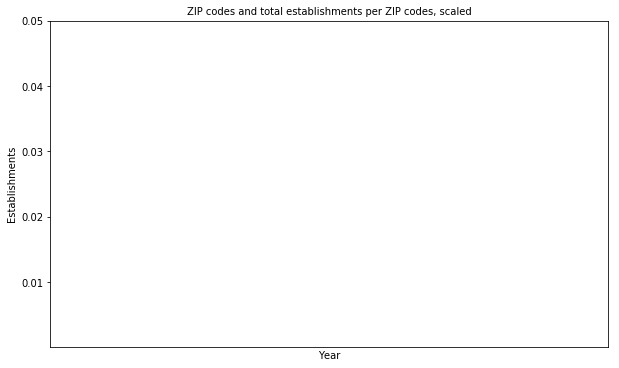

In [66]:
# we can plot the standardized dataframe
pl.figure(figsize=(10,6))
for i in range(len(scalzip)):
    plt.plot(columns, scalzip.iloc[i,0:])
pl.xlim(1994,2014)
pl.ylim(0.0001,0.05)
pl.title('ZIP codes and total establishments per ZIP codes, scaled', fontsize=10)
pl.xlabel('Year')
pl.ylabel('Establishments');

In [67]:
#from sklearn import cluster, datasets
#import sklearn
scalzip.mean(axis=1)
scalzip.mean(axis=1)
scalzip.std(axis=1)
scalzip.std(axis=1).shape

(243,)

In [71]:
#cluster with kmeans

#km = KMeans(n_clusters=nc, random_state=444).fit(vals)
X=np.asarray(scalzip.iloc[:,2:])
range_n_clusters = [2,3,4,5,6,7,8,9,10]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    #report average Silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.8601297939024262
For n_clusters =3, the average silhouette_score is :0.6780292233894204
For n_clusters =4, the average silhouette_score is :0.6139895939199155
For n_clusters =5, the average silhouette_score is :0.602597455820778
For n_clusters =6, the average silhouette_score is :0.5986092715453343
For n_clusters =7, the average silhouette_score is :0.5907949827315876
For n_clusters =8, the average silhouette_score is :0.5816541585981366
For n_clusters =9, the average silhouette_score is :0.5809014339775409
For n_clusters =10, the average silhouette_score is :0.5899648271424632
